In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np
import joblib
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [2]:
X_train = pd.read_pickle("X_train.pkl")
Y_train = pd.read_pickle("Y_train.pkl")
X_test = pd.read_pickle("X_test.pkl")
Y_test = pd.read_pickle("Y_test.pkl")

X_train_ex = pd.read_pickle("X_train_ex.pkl")
Y_train_ex = pd.read_pickle("Y_train_ex.pkl")
X_test_ex = pd.read_pickle("X_test_ex.pkl")
Y_test_ex = pd.read_pickle("Y_test_ex.pkl")

X_train = X_train.to_numpy(dtype=np.float32)
Y_train = Y_train.to_numpy(dtype=np.int64)
X_test = X_test.to_numpy(dtype=np.float32)
Y_test = Y_test.to_numpy(dtype=np.int64)

X_train_ex = X_train_ex.to_numpy(dtype=np.float32)
Y_train_ex = Y_train_ex.to_numpy(dtype=np.int64)
X_test_ex = X_test_ex.to_numpy(dtype=np.float32)
Y_test_ex = Y_test_ex.to_numpy(dtype=np.int64)

In [3]:
class ECGdataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.long)
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [5]:
print(X_train.shape)

(87553, 187)


In [4]:
train = ECGdataset(X_train, Y_train)
test = ECGdataset(X_test, Y_test)
train_ex = ECGdataset(X_train_ex, Y_train_ex)
test_ex = ECGdataset(X_test_ex, Y_test_ex)

val_ratio = 0.1
n_total = len(train)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val

train_internal, valid_internal = random_split(
    train,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_internal, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_internal, batch_size=256, shuffle=False)
test_loader = DataLoader(test, batch_size=256, shuffle=False)

val_ratio_ex = 0.1
n_total_ex = len(train_ex)
n_val_ex = int(n_total_ex * val_ratio_ex)
n_train_ex = n_total_ex - n_val_ex

train_external, valid_external = random_split(
    train_ex,
    [n_train_ex, n_val_ex],
    generator=torch.Generator().manual_seed(42)
)

train_loader_ex = DataLoader(train_external, batch_size=256, shuffle=True)
valid_loader_ex = DataLoader(valid_external, batch_size=256, shuffle=False)
test_loader_ex = DataLoader(test_ex, batch_size=256, shuffle=False)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # Mỗi khối có 2 lớp Conv 1-D với kernel size 5
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=5, stride=stride, padding=2)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=5, stride=1, padding=2)
        
        # Max Pooling ở cuối mỗi khối
        self.pool = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)

    def forward(self, x):
        identity = x
        
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        
        # Residual skip connection: Cộng input ban đầu vào output của Conv2
        out += identity 
        out = F.relu(out)
        
        out = self.pool(out)
        return out

class ECGNet(nn.Module):
    def __init__(self, num_classes=5):
        super(ECGNet, self).__init__()
        
        # Lớp Conv đầu tiên trước khi vào các khối Residual
        self.first_conv = nn.Conv1d(1, 32, kernel_size=5, stride=1, padding=2)
        
        # 5 khối Residual liên tiếp
        self.res_blocks = nn.Sequential(*[ResidualBlock(32, 32) for _ in range(5)])
        
        # 2 lớp Fully-connected với 32 neurons
        self.fc1 = nn.Linear(32, 32) 
        self.fc2 = nn.Linear(32, 32)
        self.out = nn.Linear(32, num_classes)


    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1) 
        
        x = self.first_conv(x)
        x = self.res_blocks(x)
        
        # Flatten để đưa vào FC layers
        x = F.adaptive_avg_pool1d(x, 1)  
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 
        
        return self.out(x)



In [ ]:
weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0,1,2,3,4]),
    y = Y_train
)

device = None
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# model = MLP().to(device)
model = ECGNet(num_classes=5).to(device)

weights_tensor = torch.tensor(weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for X, Y in loader:
        X = X.to(device)
        Y = Y.long().to(device)
        if X.dim() == 2:
            X = X.unsqueeze(1)

        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, Y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, Y in loader:
            X = X.to(device)
            Y = Y.to(device)

            if X.dim() == 2:
                X = X.unsqueeze(1)

            logits = model(X)
            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_labels.append(Y.cpu().numpy())

    all_probs = np.vstack(all_probs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    print(classification_report(all_labels, all_preds, digits=4))

    auc = roc_auc_score(
        all_labels,
        all_probs,
        multi_class="ovr",
        average="macro"
    )
    print("Macro AUROC:", auc)

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    return auc, cm


In [ ]:
# best_auc = 0.0
# patience = 7
# patience_counter = 0

# for epoch in range(100):
#     loss = train_epoch(model, train_loader, optimizer, criterion)
#     print(f"Epoch {epoch+1} | loss = {loss:.4f}")

#     # ===== VALIDATION (MULTI-CLASS AUC) =====
#     model.eval()
#     all_probs = []
#     all_labels = []

#     with torch.no_grad():
#         for X, Y in valid_loader:
#             X = X.to(device)
#             Y = Y.to(device)

#             if X.dim() == 2:
#                 X = X.unsqueeze(1)

#             logits = model(X)                 
#             probs = F.softmax(logits, dim=1) 

#             all_probs.append(probs.cpu().numpy())
#             all_labels.append(Y.cpu().numpy())

#     all_probs = np.vstack(all_probs)     
#     all_labels = np.concatenate(all_labels)

#     auc = roc_auc_score(
#         all_labels,
#         all_probs,
#         multi_class="ovr",
#         average="macro"
#     )

#     print(f"Val Macro AUROC: {auc:.4f}")

#     # ===== EARLY STOPPING =====
#     if auc > best_auc:
#         best_auc = auc
#         patience_counter = 0
#         torch.save(model.state_dict(), "best_model.pth")
#         print("IMPROVED ✅")
#     else:
#         patience_counter += 1
#         print(f"No improve for {patience_counter} epochs")

#         if patience_counter >= patience:
#             print("EARLY STOPPING ⛔")
#             break


Epoch 1 | loss = 0.9716
Val Macro AUROC: 0.9278
IMPROVED ✅
Epoch 2 | loss = 0.5060
Val Macro AUROC: 0.9667
IMPROVED ✅
Epoch 3 | loss = 0.4029
Val Macro AUROC: 0.9744
IMPROVED ✅
Epoch 4 | loss = 0.3402
Val Macro AUROC: 0.9773
IMPROVED ✅
Epoch 5 | loss = 0.3174
Val Macro AUROC: 0.9780
IMPROVED ✅
Epoch 6 | loss = 0.2814
Val Macro AUROC: 0.9859
IMPROVED ✅
Epoch 7 | loss = 0.2655
Val Macro AUROC: 0.9886
IMPROVED ✅
Epoch 8 | loss = 0.2430
Val Macro AUROC: 0.9889
IMPROVED ✅
Epoch 9 | loss = 0.2406
Val Macro AUROC: 0.9888
No improve for 1 epochs
Epoch 10 | loss = 0.2055
Val Macro AUROC: 0.9913
IMPROVED ✅
Epoch 11 | loss = 0.1965
Val Macro AUROC: 0.9909
No improve for 1 epochs
Epoch 12 | loss = 0.1820
Val Macro AUROC: 0.9916
IMPROVED ✅
Epoch 13 | loss = 0.1887
Val Macro AUROC: 0.9930
IMPROVED ✅
Epoch 14 | loss = 0.1676
Val Macro AUROC: 0.9900
No improve for 1 epochs
Epoch 15 | loss = 0.1633
Val Macro AUROC: 0.9933
IMPROVED ✅
Epoch 16 | loss = 0.1546
Val Macro AUROC: 0.9927
No improve for 1 epoc

In [11]:
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [12]:
print("MITBIH:")
evaluate(model, test_loader, device)


MITBIH:
              precision    recall  f1-score   support

           0     0.9918    0.9739    0.9828     18117
           1     0.6146    0.8489    0.7130       556
           2     0.9205    0.9441    0.9322      1448
           3     0.5992    0.8951    0.7178       162
           4     0.9763    0.9751    0.9757      1608

    accuracy                         0.9683     21891
   macro avg     0.8205    0.9274    0.8643     21891
weighted avg     0.9735    0.9683    0.9701     21891

Macro AUROC: 0.9931958785730008
Confusion Matrix:
[[17645   282    99    57    34]
 [   70   472    12     2     0]
 [   30     9  1367    38     4]
 [   12     0     5   145     0]
 [   33     5     2     0  1568]]


(0.9931958785730008,
 array([[17645,   282,    99,    57,    34],
        [   70,   472,    12,     2,     0],
        [   30,     9,  1367,    38,     4],
        [   12,     0,     5,   145,     0],
        [   33,     5,     2,     0,  1568]], dtype=int64))

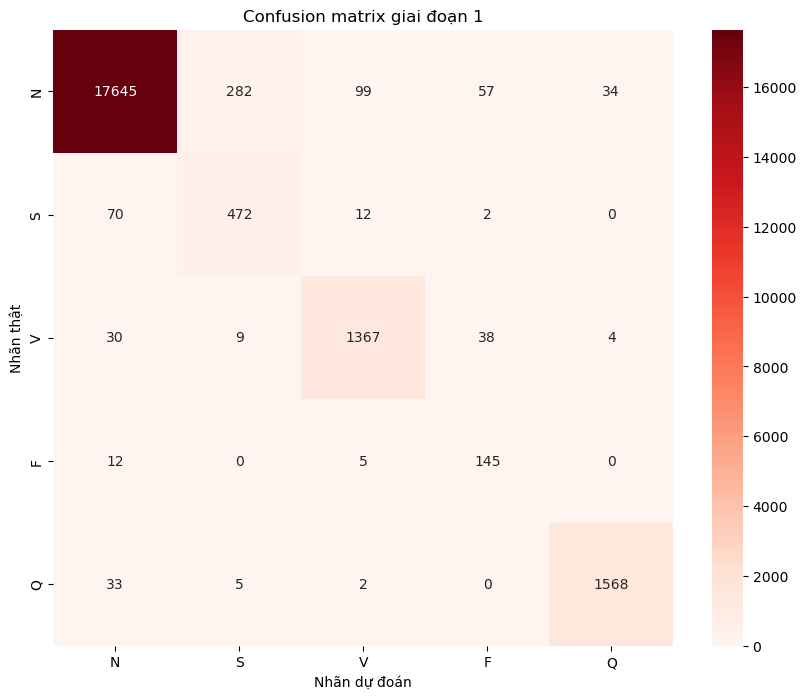

In [ ]:
cm = [[17645, 282, 99, 57, 34], 
      [70, 472, 12, 2, 0], 
      [30, 9, 1367, 38, 4], 
      [12, 0, 5, 145, 0], 
      [33, 5, 2, 0, 1568]]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['N', 'S', 'V', 'F', 'Q'],
            yticklabels=['N', 'S', 'V', 'F', 'Q'])
plt.ylabel('Nhãn thật')
plt.xlabel('Nhãn dự đoán')
plt.title('Confusion matrix giai đoạn 1')
plt.show()

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


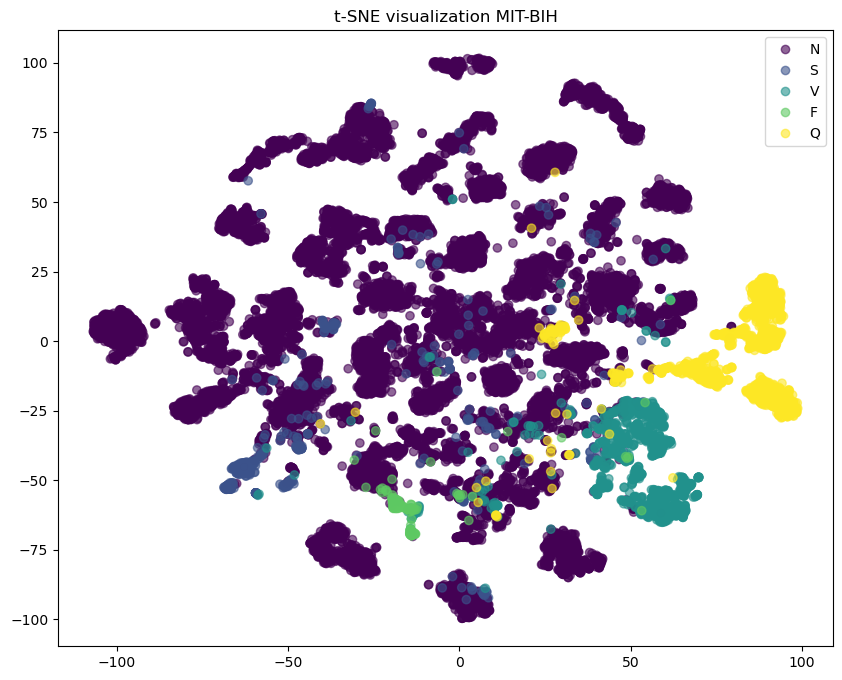

In [41]:
def extract_features(model, loader, device):
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for X, Y in loader:
            X = X.to(device)
            if X.dim() == 2: X = X.unsqueeze(1)
            
            # Chạy qua phần CNN
            x = model.first_conv(X)
            x = model.res_blocks(x)
            
            # Global Average Pooling để đưa về vector phẳng
            x = F.adaptive_avg_pool1d(x, 1)
            x = x.view(x.size(0), -1)
            
            features.append(x.cpu().numpy())
            labels.append(Y.numpy())
            
    return np.concatenate(features), np.concatenate(labels)

feat, lab = extract_features(model, test_loader, device)

# Giảm chiều xuống 2D
tsne = TSNE(n_components=2, perplexity=50, n_iter=1000, random_state=42)
feat_2d = tsne.fit_transform(feat)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(feat_2d[:, 0], feat_2d[:, 1], c=lab, cmap='viridis', alpha=0.6)
plt.legend(handles=scatter.legend_elements()[0], labels=['N', 'S', 'V', 'F', 'Q'])
plt.title("t-SNE visualization MIT-BIH")
plt.show()

In [ ]:
model_mi = ECGNet(num_classes=2).to(device)

state_dict = torch.load("best_model.pth", map_location=device)

# remove classifier trained for 5-class
del state_dict["out.weight"]
del state_dict["out.bias"]

# load remaining layers
model_mi.load_state_dict(state_dict, strict=False)

for p in model_mi.parameters():
    p.requires_grad = False

# freeze all
for p in model_mi.parameters():
    p.requires_grad = False

# unfreeze classifier
for p in model_mi.fc1.parameters(): p.requires_grad = True
for p in model_mi.fc2.parameters(): p.requires_grad = True
for p in model_mi.out.parameters(): p.requires_grad = True
optimizer_mi = torch.optim.Adam(filter(lambda p: p.requires_grad, model_mi.parameters()), lr=1e-4)

In [11]:
weights_mi = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0,1]),
    y=Y_train_ex
)

weights_tensor = torch.tensor(weights_mi, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train_epoch_mi(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for X, Y in loader:
        X = X.to(device)
        Y = Y.long().to(device)
        if X.dim() == 2:
            X = X.unsqueeze(1)

        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, Y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate_mi(model, loader):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    
    with torch.no_grad():
        for X, Y in loader:
            X = X.to(device)
            if X.dim() == 2:
                X = X.unsqueeze(1)
            
            logits = model(X)
            
            # Lấy xác suất và dự đoán
            probs = F.softmax(logits, dim=1)[:, 1] 
            preds = torch.argmax(logits, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_labels.append(Y.cpu().numpy())

    # Gộp các mảng lại thành mảng 1-D duy nhất
    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    print(classification_report(all_labels, all_preds, digits=4))
    print("AUROC:", roc_auc_score(all_labels, all_probs))
    
    # Vẽ Confusion Matrix nhị phân để xem lỗi FN (bỏ sót bệnh)
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix (PTBDB):\n", cm)



In [ ]:
# best_auc = 0
# patience = 5
# patience_counter = 0

# for epoch in range(500):
#     loss = train_epoch_mi(model_mi, train_loader_ex, optimizer_mi, criterion)
#     print(f"Epoch {epoch+1} | loss = {loss:.4f}")

#     # evaluate trên external hoặc một valid_loader
#     model.eval()
#     all_probs, all_labels = [], []
#     with torch.no_grad():
#         for X, Y in valid_loader_ex:  
#             X = X.to(device)
#             logits = model_mi(X)
#             p = F.softmax(logits, dim=1)[:, 1]
#             all_probs.extend(p.cpu().numpy())
#             all_labels.extend(Y.numpy())

#     auc = roc_auc_score(all_labels, all_probs)
#     print(f"Val AUC: {auc:.4f}")

#     # check improvement
#     if auc > best_auc:
#         best_auc = auc
#         patience_counter = 0
#         torch.save(model_mi.state_dict(), "best_model_mi1.pth")
#         print("IMPROVED")
#     else:
#         patience_counter += 1
#         print(f"no improve for {patience_counter} epochs")

#         if patience_counter >= patience:
#             print("EARLY STOPPING")
#             break


Epoch 1 | loss = 0.2182
Val AUC: 0.9559
IMPROVED
Epoch 2 | loss = 0.2177
Val AUC: 0.9561
IMPROVED
Epoch 3 | loss = 0.2169
Val AUC: 0.9563
IMPROVED
Epoch 4 | loss = 0.2163
Val AUC: 0.9562
no improve for 1 epochs
Epoch 5 | loss = 0.2166
Val AUC: 0.9562
no improve for 2 epochs
Epoch 6 | loss = 0.2169
Val AUC: 0.9563
no improve for 3 epochs
Epoch 7 | loss = 0.2168
Val AUC: 0.9565
IMPROVED
Epoch 8 | loss = 0.2164
Val AUC: 0.9567
IMPROVED
Epoch 9 | loss = 0.2165
Val AUC: 0.9566
no improve for 1 epochs
Epoch 10 | loss = 0.2158
Val AUC: 0.9564
no improve for 2 epochs
Epoch 11 | loss = 0.2157
Val AUC: 0.9566
no improve for 3 epochs
Epoch 12 | loss = 0.2157
Val AUC: 0.9566
no improve for 4 epochs
Epoch 13 | loss = 0.2150
Val AUC: 0.9563
no improve for 5 epochs
EARLY STOPPING


In [ ]:
model_mi.load_state_dict(torch.load("best_model_mi.pth"))
print("PTBDB:")
evaluate_mi(model_mi, test_loader_ex)

PTBDB:
              precision    recall  f1-score   support

           0     0.7865    0.9115    0.8444       780
           1     0.9656    0.9094    0.9367      2130

    accuracy                         0.9100      2910
   macro avg     0.8761    0.9105    0.8905      2910
weighted avg     0.9176    0.9100    0.9119      2910

AUROC: 0.964244011074997
Confusion Matrix (PTBDB):
 [[ 711   69]
 [ 193 1937]]


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


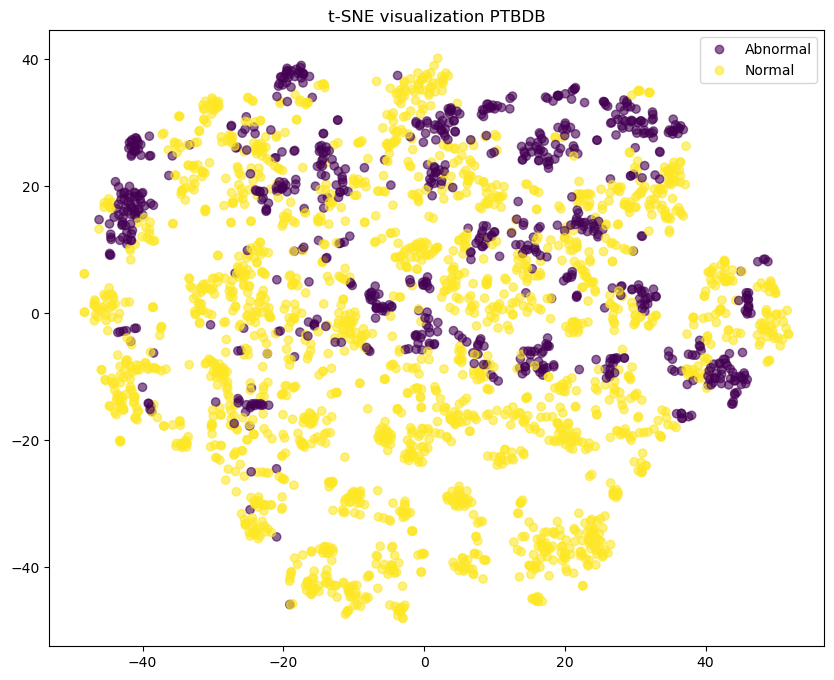

In [51]:
def extract_features(model, loader, device):
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for X, Y in loader:
            X = X.to(device)
            if X.dim() == 2: X = X.unsqueeze(1)
            
            # Chạy qua phần CNN
            x = model.first_conv(X)
            x = model.res_blocks(x)
            
            # Global Average Pooling để đưa về vector phẳng
            x = F.adaptive_avg_pool1d(x, 1)
            x = x.view(x.size(0), -1)
            
            features.append(x.cpu().numpy())
            labels.append(Y.numpy())
            
    return np.concatenate(features), np.concatenate(labels)

feat, lab = extract_features(model_mi, test_loader_ex, device)

# Giảm chiều xuống 2D
tsne = TSNE(n_components=2, perplexity=50, n_iter=1000, random_state=42)
feat_2d = tsne.fit_transform(feat)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(feat_2d[:, 0], feat_2d[:, 1], c=lab, cmap='viridis', alpha=0.6)
plt.legend(handles=scatter.legend_elements()[0], labels=['Abnormal', 'Normal'])
plt.title("t-SNE visualization PTBDB")
plt.show()

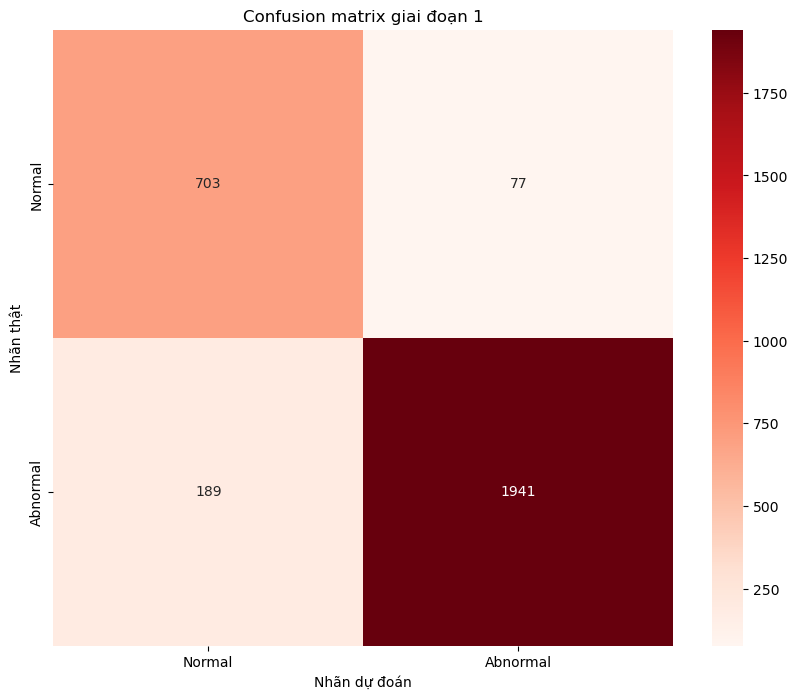

In [ ]:
cm = [[ 703, 77],
 [189, 1941]]

# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Normal', 'Abnormal'],
            yticklabels=['Normal', 'Abnormal'])
plt.ylabel('Nhãn thật')
plt.xlabel('Nhãn dự đoán')
plt.title('Confusion matrix giai đoạn 2')
plt.show()